# Pre-SN Outburst Detection & Analysis

We use our script `bump_detection.py` to add Gaussian outburst simulations to control light curve flux and determine whether our bump detection algorithm successfully detects these simulations. We determine efficiencies for different Gaussian simulation kernel sizes and peak magnitudes, as well as different algorithm kernel sizes.

Each simulation is recorded and saved into a table corresponding to its peak magnitude. In this notebook, we can load these tables and calculate efficiencies for the previously mentioned parameters by counting the number of successful and failed detections. We additionally calculate contamination for our detection limits using control light curve flux.

All light curves used for the bump analysis must be averaged. We use our download script `download_atlas_lc.py` to query ATLAS machines for SN and control light curves; and our cleaning script `clean_atlas_lc_v2.py` to clean and average them. Please refer to the documentation and scripts on GitHub to do so.

In [1]:
##### LOADING THE AVERAGED SN LIGHT CURVE #####

# Enter the target SN name:
tnsname = '2023ixf'

# Enter the path to the data directory that contains the SN directory:
source_dir = f'/Users/sofiarest/Desktop/Supernovae/data/temp2' 

# Enter the path to the parent directory that contains any files to do with bump analysis:
output_dir = f'{source_dir}/{tnsname}/bump_analysis'

# Enter the path to the directory that contains the simulation detection tables:
tables_dir = f'{output_dir}/tables_allmjd'

# Enter the path to a directory to optionally save any plots:
plots_dir = f'{output_dir}/plots_test' #'/Users/sofiarest/Google Drive/My Drive/College/STScI Research Paper/2023ixf_paper'

# Enter the filter for this averaged light curve (must be 'o' or 'c'):
filt = 'o'

# Enter the MJD bin size for the averaged light curve (should be in file name):
mjd_bin_size = 1.0 

# Optionally, enter the SN's discovery date (if None is entered, it will be 
# fetched automatically from TNS using the API key, TNS ID, and bot name):
discovery_date = 60063.727257
api_key = None
tns_id = None
bot_name = None

##### LOADING AVERAGED CONTROL LIGHT CURVES #####

# Set to True if you are planning on applying the control light curve cut 
# and have already downloaded the control light curves:
load_controls = True

# Enter the number of control light curves to load:
n_controls = 16 #8

# Enter the source directory of the control light curve files:
controls_dir = f'{source_dir}/{tnsname}/controls'

## Miscellaneous functions (skip this section)

In [2]:
import sys
#sys.path.insert(1,'../')
import pandas as pd
import numpy as np
import copy,math,os
from scipy import interpolate
from pdastro import pdastrostatsclass
#from asym_gaussian import gauss2lc
from atlas_lc import atlas_lc
from bump_detection import AandB, AnotB, SimDetecLightCurve, EfficiencyTable, Gaussian, flux2mag, mag2flux, in_valid_season, load_sd_dict #Eruption

# plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 'Mask' column flags
flags = {'chisquare':0x1, 
		 'uncertainty':0x2,
		 'controls_bad':0x400000,
		 'avg_badday':0x800000}

# default plotting styles
plt.rc('axes', titlesize = 17)
plt.rc('xtick', labelsize = 11)
plt.rc('ytick', labelsize = 11)
plt.rc('legend', fontsize = 9)
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['red', 'orange', 'green', 'blue', 'purple', 'magenta'])
matplotlib.rcParams['xtick.major.size'] = 6
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['xtick.minor.size'] = 3
matplotlib.rcParams['xtick.minor.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 6
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.minor.size'] = 3
matplotlib.rcParams['ytick.minor.width'] = 1
matplotlib.rcParams['axes.linewidth'] = 1
marker_size = 30
marker_edgewidth = 1.5
simbump_ls = 'dashed'
fomlimit_ls = 'dotted'
# plotting color scheme
# flux
sn_flux = 'orange'
sn_flagged_flux = 'red'
#ctrl_flux = 'limegreen'
select_ctrl_flux = 'forestgreen' #'darkgreen'
# FOM
sn_fom = 'deeppink'#'magenta'
ctrl_fom = 'cornflowerblue'
select_ctrl_fom = 'mediumblue'

# suppress matplotlib warnings
import warnings
warnings.simplefilter('error', RuntimeWarning)
warnings.filterwarnings("ignore")

def save_plot(save_filename=None):
    if not save_filename is None:
        filename = f'{plots_dir}/{save_filename}.png'
        if not os.path.exists(plots_dir):
            os.makedirs(plots_dir)
        print(f'Saving plot: {filename}')
        plt.savefig(filename, dpi=200)

## Load the averaged ATLAS light curve

In [3]:
print(f'SN {tnsname}, filter {filt}, MJD bin size {mjd_bin_size} day(s), {n_controls} control light curves')
if not discovery_date is None:
    print(f'SN discovery date: {discovery_date}')
print(f'Source directory (load SN light curve): {source_dir}/{tnsname}')
if load_controls: 
    print(f'Controls directory (load control light curves): {controls_dir}')
print(f'Output directory: {output_dir}')
print(f'Simulation detection tables directory: {tables_dir}')
print(f'Directory for saving plots: {plots_dir}')

SN 2023ixf, filter o, MJD bin size 1.0 day(s), 16 control light curves
SN discovery date: 60063.727257
Source directory (load SN light curve): /Users/sofiarest/Desktop/Supernovae/data/temp2/2023ixf
Controls directory (load control light curves): /Users/sofiarest/Desktop/Supernovae/data/temp2/2023ixf/controls
Output directory: /Users/sofiarest/Desktop/Supernovae/data/temp2/2023ixf/bump_analysis
Simulation detection tables directory: /Users/sofiarest/Desktop/Supernovae/data/temp2/2023ixf/bump_analysis/tables_allmjd
Directory for saving plots: /Users/sofiarest/Desktop/Supernovae/data/temp2/2023ixf/bump_analysis/plots_test


In [4]:
if filt != 'o' and filt != 'c': 
	raise RuntimeError('Filter must be "o" or "c"!')

# load cleaned light curve
og_lc = atlas_lc(tnsname=tnsname, discdate=discovery_date)
# load averaged light curve
lc = SimDetecLightCurve(filt, mjd_bin_size, tnsname=tnsname, discdate=discovery_date)

# get discovery date
if lc.discdate is None:
	lc._get_tns_data(tnsname, api_key, tns_id, bot_name)
	og_lc.set_tns_data(lc.ra, lc.dec, lc.discdate)
	
# load cleaned SN and control light curves
og_lc._load(source_dir, filt, 0)

# load averaged SN and control light curves
lc.load(source_dir, num_controls=n_controls)


Loading SN light curve and 0 control light curves...

Loading averaged SN light curve and 16 averaged control light curves...


### Plot cleaned original and averaged pre-SN light curves

In [5]:
# Enter MJD ranges (observation seasons): 
mjd_ranges = [[57365,57622],
              [57762,57983], 
              [58120,58383], 
              [58494,58741-41], 
              [58822+28,59093], 
              [59184,59445], 
              [59566,59835], 
              [59901,60085]]

# Plot MJD ranges (observation seasons)?:
plot_mjd_ranges = False

# Enter plot y limits (set to None for automatic):
ylims = (-300, 400)

# Save plot?:
save = False

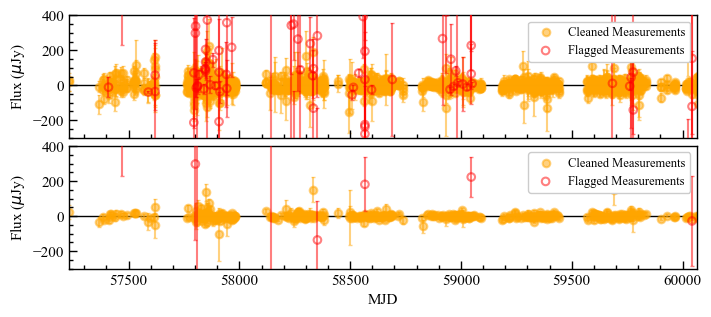

In [6]:
def plot_preSN_lcs(og_lc, lc, ylims=None, plot_mjd_ranges=False, save=False):
    fig, (ax1, ax2) = plt.subplots(2, constrained_layout=True)
    fig.set_figwidth(7)
    fig.set_figheight(3)

    # original lc 
    
    if not ylims is None:
        ax1.set_ylim(ylims[0], ylims[1])
    ax1.set_xlim(og_lc.lcs[0].t.loc[0,'MJD'],discovery_date)
    ax1.minorticks_on()
    ax1.set_xticklabels([])
    ax1.tick_params(direction='in', which='both')
    ax1.set_ylabel(r'Flux ($\mu$Jy)')
    ax1.axhline(linewidth=1, color='k', zorder=0)

    good_ix = og_lc.get_unmasked_ix(flags)
    bad_ix = AnotB(og_lc.get_ix(),good_ix)

    # cleaned
    ax1.errorbar(og_lc.lcs[0].t.loc[good_ix,'MJD'], og_lc.lcs[0].t.loc[good_ix,'uJy'], yerr=og_lc.lcs[0].t.loc[good_ix,'duJy'], fmt='none', ecolor=sn_flux, elinewidth=1.5, capsize=1.2, c=sn_flux, alpha=0.5, zorder=0)
    ax1.scatter(og_lc.lcs[0].t.loc[good_ix,'MJD'], og_lc.lcs[0].t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=sn_flux, marker='o', alpha=0.5, label=f'Cleaned Measurements', zorder=0)

    # flagged
    ax1.errorbar(og_lc.lcs[0].t.loc[bad_ix,'MJD'], og_lc.lcs[0].t.loc[bad_ix,'uJy'], yerr=og_lc.lcs[0].t.loc[bad_ix,'duJy'], fmt='none', ecolor=sn_flagged_flux, elinewidth=1.5, capsize=1.2, c=sn_flagged_flux, alpha=0.5, zorder=10)
    ax1.scatter(og_lc.lcs[0].t.loc[bad_ix,'MJD'], og_lc.lcs[0].t.loc[bad_ix,'uJy'], s=marker_size, lw=marker_edgewidth, facecolors='none', edgecolors=sn_flagged_flux, marker='o', alpha=0.5, label=f'Flagged Measurements', zorder=10)

    # averaged lc

    ax2.set_ylim(ylims[0], ylims[1])
    ax2.set_xlim(og_lc.lcs[0].t.loc[0,'MJD'],discovery_date)
    ax2.minorticks_on()
    ax2.tick_params(direction='in', which='both')
    ax2.set_ylabel(r'Flux ($\mu$Jy)')
    ax2.set_xlabel('MJD')
    ax2.axhline(linewidth=1, color='k', zorder=0)

    good_ix = lc.get_unmasked_ix(flags) 
    bad_ix = AnotB(lc.get_ix(),good_ix)

    # cleaned
    ax2.errorbar(lc.lcs[0].t.loc[good_ix,'MJD'], lc.lcs[0].t.loc[good_ix,'uJy'], yerr=lc.lcs[0].t.loc[good_ix,'duJy'], fmt='none', ecolor=sn_flux, elinewidth=1.5, capsize=1.2, c=sn_flux, alpha=0.5, zorder=0)
    ax2.scatter(lc.lcs[0].t.loc[good_ix,'MJD'], lc.lcs[0].t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=sn_flux, marker='o', alpha=0.5, label=f'Cleaned Measurements', zorder=0)

    # flagged
    ax2.errorbar(lc.lcs[0].t.loc[bad_ix,'MJD'], lc.lcs[0].t.loc[bad_ix,'uJy'], yerr=lc.lcs[0].t.loc[bad_ix,'duJy'], fmt='none', ecolor=sn_flagged_flux, elinewidth=1.5, capsize=1.2, c=sn_flagged_flux, alpha=0.5, zorder=10)
    ax2.scatter(lc.lcs[0].t.loc[bad_ix,'MJD'], lc.lcs[0].t.loc[bad_ix,'uJy'], s=marker_size, lw=marker_edgewidth, facecolors='none', edgecolors=sn_flagged_flux, marker='o', alpha=0.5, label=f'Flagged Measurements', zorder=10)

    if plot_mjd_ranges:
        # valid mjd ranges
        for mjd_range in mjd_ranges:
            ax1.axvline(mjd_range[0], color='k', linestyle='dashed')
            ax1.axvline(mjd_range[1], color='k', linestyle='dashed')
            ax2.axvline(mjd_range[0], color='k', linestyle='dashed')
            ax2.axvline(mjd_range[1], color='k', linestyle='dashed')

    ax1.legend(loc='upper right', facecolor='white', framealpha=1.0).set_zorder(100)
    ax2.legend(loc='upper right', facecolor='white', framealpha=1.0).set_zorder(100)

    if save:
        save_plot(save_filename=f'cleaned_avg')

plot_preSN_lcs(og_lc, lc, ylims=ylims, plot_mjd_ranges=plot_mjd_ranges, save=save)

### Plot all control light curves

In [7]:
# Enter plot x limits (set to None for automatic):
xlims = None #(57200, 58100)

# Enter plot y limits (set to None for automatic):
ylims = (-250,250)

# Save plot?:
save = False

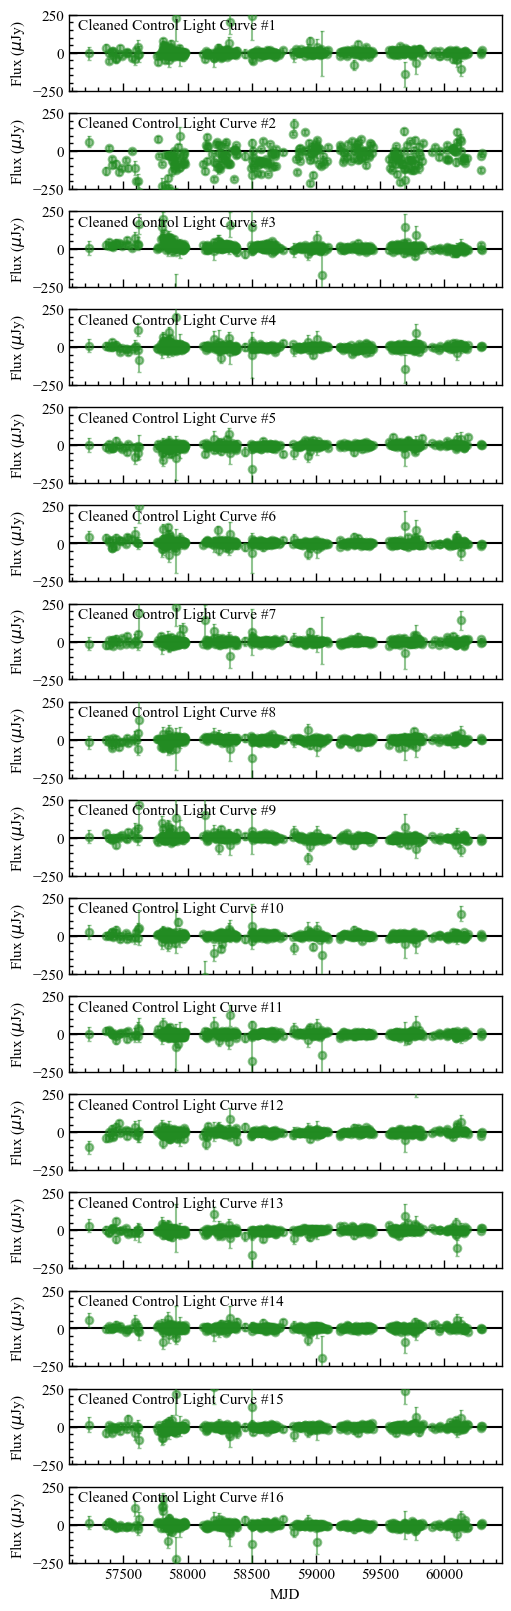

In [8]:
# so that we can try to exclude them
# n-panel plot with panels stacked on top of each other

def plot_control_lcs(lc, ylims=None, save=False):
    fig, axes = plt.subplots(lc.num_controls, constrained_layout=True)
    fig.set_figheight(lc.num_controls)
    fig.set_figwidth(5)

    for i in range(lc.num_controls):
        control_index = i + 1
        axes[i].minorticks_on()
        axes[i].tick_params(direction='in', which='both')

        if i < lc.num_controls-1: 
            axes[i].set_xticklabels([])
        else:
            axes[i].set_xlabel('MJD')

        axes[i].set_ylabel(r'Flux ($\mu$Jy)')

        if not ylims is None:
            axes[i].set_ylim(ylims[0], ylims[1])
        if not xlims is None:
            axes[i].set_xlim(xlims[0], xlims[1])

        axes[i].axhline(color='k', zorder=0)

        good_ix = lc.get_unmasked_ix(flags, control_index=control_index) 
        axes[i].errorbar(lc.lcs[control_index].t.loc[good_ix,'MJD'], lc.lcs[control_index].t.loc[good_ix,'uJy'], yerr=lc.lcs[control_index].t.loc[good_ix,'duJy'], fmt='none', ecolor=select_ctrl_flux, elinewidth=1.5, capsize=1.2, c=select_ctrl_flux, alpha=0.5, zorder=10)
        axes[i].scatter(lc.lcs[control_index].t.loc[good_ix,'MJD'], lc.lcs[control_index].t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=select_ctrl_flux, marker='o', alpha=0.5, zorder=10)

        axes[i].text(.02, .95, f'Cleaned Control Light Curve #{control_index}', 
                    ha='left', va='top', transform=axes[i].transAxes, fontsize=11, zorder=20)

    plt.show()

    if save:
        save_plot(save_filename=f'controls')

plot_control_lcs(lc, ylims=ylims, save=save)

### Plot averaged pre-SN and selected control light curve

In [9]:
# Enter the index of the control light curve to plot:
select_index = 7

# Enter plot y limits (set to None for automatic):
ylims = (-150, 200)

# Save plot?:
save = False

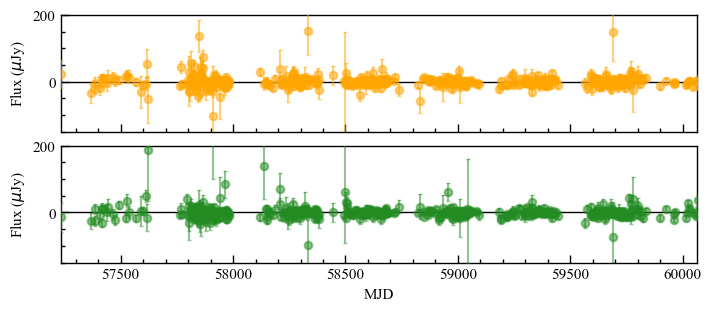

In [10]:
def plot_preSN_control_lcs(lc, select_index, ylims=None, save=False):
	fig, (ax1, ax2) = plt.subplots(2, constrained_layout=True)
	fig.set_figwidth(7)
	fig.set_figheight(3)

	ax1.set_ylim(ylims[0], ylims[1])
	ax1.set_xlim(lc.lcs[0].t.loc[0,'MJD'],discovery_date)
	ax1.minorticks_on()
	ax1.set_xticklabels([])
	ax1.tick_params(direction='in', which='both')
	ax1.set_ylabel(r'Flux ($\mu$Jy)')
	ax1.axhline(linewidth=1, color='k', zorder=0)

	# pre-SN lc flux
	good_ix = lc.get_unmasked_ix(flags) 
	ax1.errorbar(lc.lcs[0].t.loc[good_ix,'MJD'], lc.lcs[0].t.loc[good_ix,'uJy'], yerr=lc.lcs[0].t.loc[good_ix,'duJy'], fmt='none', ecolor=sn_flux, elinewidth=1.5, capsize=1.2, c=sn_flux, alpha=0.5, zorder=20)
	ax1.scatter(lc.lcs[0].t.loc[good_ix,'MJD'], lc.lcs[0].t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=sn_flux, marker='o', alpha=0.5, label=f'Cleaned Pre-SN Light Curve', zorder=20)

	ax2.set_ylim(ylims[0], ylims[1])
	ax2.set_xlim(lc.lcs[0].t.loc[0,'MJD'],discovery_date)
	ax2.minorticks_on()
	ax2.tick_params(direction='in', which='both')
	ax2.set_ylabel(r'Flux ($\mu$Jy)')
	ax2.set_xlabel('MJD')
	ax2.axhline(linewidth=1, color='k', zorder=0)

	# control lc flux
	good_ix = lc.get_unmasked_ix(flags, control_index=select_index) 
	ax2.errorbar(lc.lcs[select_index].t.loc[good_ix,'MJD'], lc.lcs[select_index].t.loc[good_ix,'uJy'], yerr=lc.lcs[select_index].t.loc[good_ix,'duJy'], fmt='none', ecolor=select_ctrl_flux, elinewidth=1.5, capsize=1.2, c=select_ctrl_flux, alpha=0.5, zorder=10)
	ax2.scatter(lc.lcs[select_index].t.loc[good_ix,'MJD'], lc.lcs[select_index].t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=select_ctrl_flux, marker='o', alpha=0.5, label=f'Cleaned Control Light Curve #{select_index}', zorder=10)

	if save:
		save_plot(save_filename=f'avg_control')

plot_preSN_control_lcs(lc, select_index, ylims=ylims, save=save)

## Get preliminary detection limits and contamination

### Get preliminary $3\sigma$ and $5\sigma$ detection limits $\Sigma_{\rm FOM, limit}$

For each $\sigma_{kernel}$:
1. Apply a $3\sigma$-cut to its corresponding $\Sigma_{\rm FOM}$ distribution and obtain the standard deviation $\sigma$.
2. Obtain the $3\sigma$ and $5\sigma$ detection limits $\Sigma_{\rm FOM,limit}$.

In [11]:
# Exclude certain control lcs from the analysis 
# (set to empty list [] for no exclusions):
skip_control_ix = [2, 3]

# Optionally remove bad MJD range(s):
mjd_ranges_remove = [[57365,57622], [57762,57983]]

# Sigmas of weighted gaussian rolling sums:
sigma_kerns = [5, 15, 25, 40, 80, 130, 200, 300]

In [12]:
def get_valid_seasons(all_seasons, seasons_to_remove):
    if seasons_to_remove is None:
        return all_seasons
    return [season for season in all_seasons if not season in seasons_to_remove]

def get_all_fom_dict(lc, sigma_kerns, skip_control_ix, valid_seasons):
    all_fom_dict = { sigma_kern: None for sigma_kern in sigma_kerns } 
    print(f'Getting all FOM for valid seasons {valid_seasons}...')
    for i in range(len(sigma_kerns)):
        sigma_kern = sigma_kerns[i]
        allfom = pd.Series()
        for control_index in range(1, lc.num_controls+1):
            if control_index in skip_control_ix:
                continue
            lc.apply_rolling_sum(control_index, sigma_kern)
            ix = lc.get_valid_ix(control_index, valid_seasons)
            allfom = pd.concat([allfom, lc.lcs[control_index].t.loc[ix,'SNRsumnorm']], ignore_index=True)
        all_fom_dict[sigma_kern] = allfom
    return all_fom_dict

def get_fom_limits(sigma_kern, all_fom):#, plot=False):
    df = pdastrostatsclass(columns=['SNRsumnorm'])
    df.t['SNRsumnorm'] = all_fom
    df.calcaverage_sigmacutloop('SNRsumnorm', Nsigma=3.0, median_firstiteration=True)
    stdev = df.statparams["stdev"]
    mean = df.statparams["mean"]
    fom_limit_3sig = mean + 3*stdev
    fom_limit_5sig = mean + 5*stdev
    print(f'sigma_kern={sigma_kern}: stdev={df.statparams["stdev"]:0.2f}, 3*stdev={fom_limit_3sig:0.2f}, 5*stdev={fom_limit_5sig:0.2f}')
    return fom_limit_3sig, fom_limit_5sig

def get_all_fom_limits(sigma_kerns, all_fom_dict):
    print(f'Getting FOM limits for sigma_kerns {sigma_kerns}')
    fom_limits = { sigma_kern: None for sigma_kern in sigma_kerns }
    for sigma_kern in sigma_kerns: 
        fom_limit_3sig, fom_limit_5sig = get_fom_limits(sigma_kern, all_fom_dict[sigma_kern])
        fom_limits[sigma_kern] = [round(fom_limit_3sig, 2), round(fom_limit_5sig, 2)]
    return fom_limits

print(f'Skipping control light curve indices {skip_control_ix}')
print(f'Excluding MJD ranges {mjd_ranges_remove} from analysis')

valid_seasons = get_valid_seasons(mjd_ranges, mjd_ranges_remove)
all_fom_dict = get_all_fom_dict(lc, sigma_kerns, skip_control_ix, valid_seasons)
all_fom_limits = get_all_fom_limits(sigma_kerns, all_fom_dict)

# do the same for mjd_ranges_remove
#all_fom_dict_remove = get_all_fom_dict(lc, sigma_kerns, skip_control_ix, mjd_ranges_remove)
#fom_limits_remove = get_all_fom_limits(sigma_kerns, all_fom_dict_remove)

Skipping control light curve indices [2, 3]
Excluding MJD ranges [[57365, 57622], [57762, 57983]] from analysis
Getting all FOM for valid seasons [[58120, 58383], [58494, 58700], [58850, 59093], [59184, 59445], [59566, 59835], [59901, 60085]]...


Getting FOM limits for sigma_kerns [5, 15, 25, 40, 80, 130, 200, 300]
sigma_kern=5: stdev=1.74, 3*stdev=5.13, 5*stdev=8.61
sigma_kern=15: stdev=3.66, 3*stdev=10.74, 5*stdev=18.06
sigma_kern=25: stdev=5.39, 3*stdev=15.77, 5*stdev=26.55
sigma_kern=40: stdev=7.76, 3*stdev=22.67, 5*stdev=38.19
sigma_kern=80: stdev=12.66, 3*stdev=36.86, 5*stdev=62.18
sigma_kern=130: stdev=17.64, 3*stdev=51.13, 5*stdev=86.40
sigma_kern=200: stdev=24.70, 3*stdev=71.27, 5*stdev=120.68
sigma_kern=300: stdev=34.38, 3*stdev=98.82, 5*stdev=167.59


### Plot preliminary detection limits $\Sigma_{\rm FOM,limit}$

In [13]:
# Plot illustratory histograms?:
plot = True

# Enter plot x limits (set to None for automatic):
xlims = (-100,300)

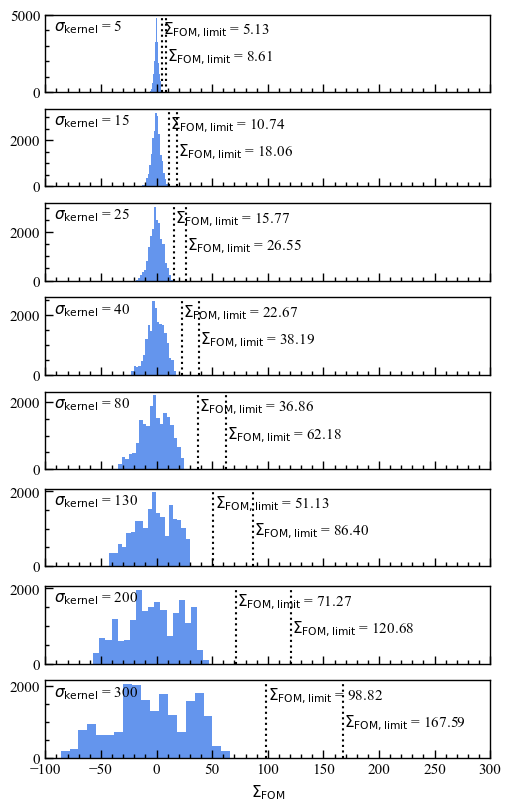

In [14]:
def plot_fom_dists(sigma_kerns, all_fom_dict, all_fom_limits, xlims=None):
    n = len(sigma_kerns)
    fig, axes = plt.subplots(n, constrained_layout=True)
    fig.set_figheight(n)
    fig.set_figwidth(5)

    if xlims is None:
        xlim_lower = np.inf
        xlim_upper = -np.inf
        for sigma_kern in sigma_kerns:
            max_fom = max(max(all_fom_dict[sigma_kern]), all_fom_limits[sigma_kern][1])
            min_fom = min(all_fom_dict[sigma_kern])
            xlim_upper = max_fom if max_fom > xlim_upper else xlim_upper
            xlim_lower = min_fom if min_fom < xlim_lower else xlim_lower

    for i in range(n):
        sigma_kern = sigma_kerns[i]
        all_fom = all_fom_dict[sigma_kern]
        fom_limits = all_fom_limits[sigma_kern]

        axes[i].minorticks_on()
        axes[i].tick_params(direction='in', which='both')
        if i < n-1: 
            axes[i].set_xticklabels([])
        else:
            axes[i].set_xlabel(r'$\Sigma_{\rm FOM}$')
        
        if xlims is None:
            axes[i].set_xlim(xlim_lower-1, xlim_upper+120)
        else:
            axes[i].set_xlim(xlims[0], xlims[1])

        bins = np.linspace(min(all_fom), max(all_fom), 20)

        axes[i].text(.02, .95, r'$\sigma_{\rm kernel}$ = '+str(sigma_kern), 
                    ha='left', va='top', transform=axes[i].transAxes, fontsize=11)
        axes[i].hist(all_fom, bins=bins, color=ctrl_fom)

        ylim_upper = axes[i].get_ylim()[1]
        if len(fom_limits) > 1:
            axes[i].axvline(fom_limits[0], linewidth=1.5, color='k', linestyle=fomlimit_ls)#, label=r'$\Sigma_{\rm FOM, limit} (3\sigma)$ = '+f'{fom_limits[0]:0.2f}') 
            axes[i].text(fom_limits[0]+1, 0.75*ylim_upper, r'$\Sigma_{\rm FOM, limit}$ = '+f'{fom_limits[0]:0.2f}', fontsize=11)
            axes[i].axvline(fom_limits[1], linewidth=1.5, color='k', linestyle=fomlimit_ls)#, label=r'$\Sigma_{\rm FOM, limit} (5\sigma)$ = '+f'{fom_limits[1]:0.2f}') 
            axes[i].text(fom_limits[1]+1, 0.4*ylim_upper, r'$\Sigma_{\rm FOM, limit}$ = '+f'{fom_limits[1]:0.2f}', fontsize=11)
        else:
            axes[i].axvline(fom_limits[0], linewidth=1.5, color='k', linestyle=fomlimit_ls)
            axes[i].text(fom_limits[0]+1, 0.75*ylim_upper, r'$\Sigma_{\rm FOM, limit}$ = '+f'{fom_limits[0]:0.2f}', fontsize=11)

if plot:
    plot_fom_dists(sigma_kerns, all_fom_dict, all_fom_limits, xlims=xlims)

### Plot light curve $\Sigma_{\rm FOM}$ with preliminary detection limits $\Sigma_{\rm FOM, limit}$

Applying rolling sum to 16 control light curves...


Applying rolling sum to 16 control light curves...
Applying rolling sum to 16 control light curves...


'\nfor sigma_kern in sigma_kerns:\n    plot_fom(lc, sigma_kern, skip_control_ix, all_fom_limits[sigma_kern], all_fom_dict[sigma_kern], valid_seasons=valid_seasons)\n'

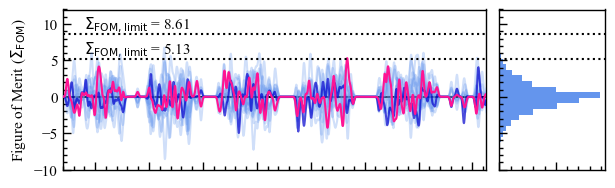

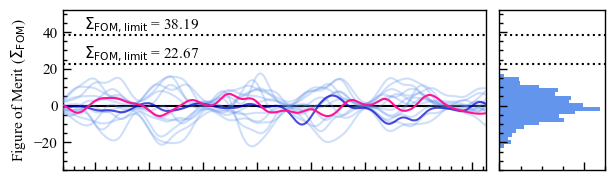

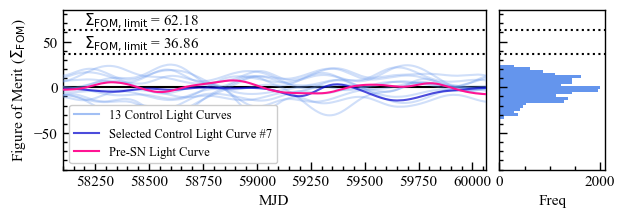

In [15]:
def plot_fom(lc, sigma_kern, skip_control_ix, fom_limits, all_fom, valid_seasons=None, vlines=None, show_xlabels=True, ylims=None, save=False):
    preSN_ix = lc.get_pre_SN_ix(colname='MJDbin')
    lc.apply_rolling_sum(0, sigma_kern, indices=preSN_ix)
    lc.apply_rolling_sums(sigma_kern)

    fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [4, 1]})
    fig.set_figwidth(7)
    fig.set_figheight(2)
    fig.subplots_adjust(wspace=0.05, bottom=0.1, top=0.9)

    ax1.minorticks_on()
    ax1.tick_params(direction='in', which='both')
    ax1.set_ylabel(r'Figure of Merit ($\Sigma_{\rm FOM}$)')
    ax1.axhline(linewidth=1.5, color='k', zorder=0)
    ax1.set_xlim(valid_seasons[0][0]-20, min(valid_seasons[-1][1]+20, lc.discdate))
    if show_xlabels:
        ax1.set_xlabel('MJD')
    else:
        plt.setp(ax1.get_xticklabels(), visible=False)
    if ylims is None:
        ax1.set_ylim(min(all_fom)*1.5, max(max(all_fom)*1.3, fom_limits[-1]*1.3))
    else: 
        ax1.set_ylim(ylims[0], ylims[1]) 

    # control lcs fom
    for control_index in range(1, n_controls):
        if control_index in skip_control_ix or control_index == select_index:
            continue
        ax1.plot(lc.lcs[control_index].t['MJDbin'], lc.lcs[control_index].t['SNRsumnorm'], color=ctrl_fom, alpha=0.3, zorder=10)
    ax1.plot([0,1],[0,0], color=ctrl_fom, linewidth=1.5,  alpha=0.6, zorder=0, label=f'{n_controls-len(skip_control_ix)-1} Control Light Curves')
    # selected control lc fom
    ax1.plot(lc.lcs[select_index].t['MJDbin'], lc.lcs[select_index].t['SNRsumnorm'], color=select_ctrl_fom, linewidth=1.5, alpha=0.7, zorder=20, label=f'Selected Control Light Curve #{select_index}')

    # pre-SN lc fom
    ax1.plot(lc.lcs[0].t['MJDbin'], lc.lcs[0].t['SNRsumnorm'], color=sn_fom, linewidth=1.5, label='Pre-SN Light Curve', zorder=40)

    # fom limits
    for fom_limit in fom_limits:
        ax1.axhline(fom_limit, linewidth=1.5, color='k', linestyle=fomlimit_ls, zorder=50) 
        ax1.text(0.05, fom_limit, r'$\Sigma_{\rm FOM, limit}$ = '+str(fom_limit), color="k", transform=ax1.get_yaxis_transform(), ha="left", va="bottom") 

    if not vlines is None:
        for vline in vlines:
            ax1.axvline(vline, linewidth=1.5, color='orange', zorder=60)

    if show_xlabels:
        ax1.legend(loc='lower left', facecolor='white', fontsize=9, framealpha=1.0).set_zorder(100)

    # FOM histogram
    ax2.hist(all_fom, bins=20, orientation="horizontal", color=ctrl_fom)
    ylim_upper, ylim_lower = ax1.get_ylim()
    ax2.set_ylim(ylim_upper, ylim_lower) 
    ax2.yaxis.set_tick_params(labelbottom=False)
    if show_xlabels:
        ax2.set_xlabel('Freq')
    else:
        plt.setp(ax2.get_xticklabels(), visible=False)
    ax2.minorticks_on()
    ax2.tick_params(direction='in', which='both')
    for fom_limit in fom_limits:
        ax2.axhline(fom_limit, linewidth=1.5, color='k', linestyle=fomlimit_ls, zorder=40) 

    if save:
        save_plot(save_filename=f'all_foms_{sigma_kern}')

plot_fom(lc, 5, skip_control_ix, all_fom_limits[5], all_fom_dict[5], valid_seasons=valid_seasons, show_xlabels=False, ylims=(-10,12))#, vlines=[valid_seasons[0][0]])
plot_fom(lc, 40, skip_control_ix, all_fom_limits[40], all_fom_dict[40], valid_seasons=valid_seasons, show_xlabels=False, ylims=(-35, 52))
plot_fom(lc, 80, skip_control_ix, all_fom_limits[80], all_fom_dict[80], valid_seasons=valid_seasons, ylims=(-90, 85))

"""
for sigma_kern in sigma_kerns:
    plot_fom(lc, sigma_kern, skip_control_ix, all_fom_limits[sigma_kern], all_fom_dict[sigma_kern], valid_seasons=valid_seasons)
"""

### Get contamination using preliminary detection limits $\Sigma_{\rm FOM, limit}$

In [16]:
# Save contamination table to tables_dir?:
save = False

In [17]:
def get_n_triggers(lc, control_index, sigma_kern, fom_limit, valid_seasons, verbose=False):
    valid_ix = lc.get_valid_ix(control_index, valid_seasons)
    if control_index == 0:
        preSN_ix = lc.get_pre_SN_ix(colname='MJDbin')
        valid_ix = AandB(preSN_ix, valid_ix)
        lc.apply_rolling_sum(0, sigma_kern, indices=preSN_ix)
    else:
        lc.apply_rolling_sum(control_index, sigma_kern)

    # find any triggers above the fom limit
    count = 0
    mjds = []
    above_lim = False
    for k in valid_ix: 
        if lc.lcs[control_index].t.loc[k, 'SNRsumnorm'] > fom_limit:
            if not above_lim: 
                mjd = lc.lcs[control_index].t.loc[k, "MJDbin"]
                if control_index > 0: # control lc
                    mjds.append(mjd)
                    count += 1
                elif mjd < discovery_date: # MJD must be in pre-SN lc
                    mjds.append(mjd)
                    count += 1
            above_lim = True
        else:
            above_lim = False
    
    if verbose and len(mjds) > 0:
        print(f'sigma_kern {sigma_kern}, fom limit {fom_limit:0.2f}, control index {control_index}: {count} trigger(s) at mjds {mjds}')
    return count

def get_contamination(lc, sigma_kern, fom_limit, valid_seasons, skip_control_ix, verbose=False):
    row = {
        'sigma_kern': sigma_kern,
        'fom_limit': fom_limit,
        'n_triggers': 0,
        'n_controls_triggered': 0,
        'pct_controls_triggered': np.nan,
    }

    for control_index in range(lc.num_controls+1):
        if control_index in skip_control_ix:
            continue

        n_triggers = get_n_triggers(lc, control_index, sigma_kern, fom_limit, valid_seasons, verbose=verbose)
        row[f'n_triggers_{control_index:02d}'] = n_triggers

        if control_index > 0 and n_triggers > 0:
            row['n_controls_triggered'] += 1
            row['n_triggers'] += n_triggers

    row['pct_controls_triggered'] = round(100 * row['n_controls_triggered'] / (lc.num_controls-len(skip_control_ix)), 2)
    return row

def get_contamination_table(lc, sigma_kerns, all_fom_limits, valid_seasons, skip_control_ix, verbose=False, save=False):
    print('Calculating contamination table...')
    contam = pd.DataFrame()

    for sigma_kern in sigma_kerns:
        for fom_limit in all_fom_limits[sigma_kern]:
            row = get_contamination(lc, sigma_kern, fom_limit, valid_seasons, skip_control_ix, verbose=verbose)
            contam = pd.concat([contam, pd.DataFrame([row])], ignore_index=True)

    if save:
        contam.to_string(f'{tables_dir}/contamination.txt')
    return contam

contam = get_contamination_table(lc, sigma_kerns, all_fom_limits, valid_seasons, skip_control_ix, save=save, verbose=True)
print(contam.to_string())

Calculating contamination table...
sigma_kern 5, fom limit 5.13, control index 0: 1 trigger(s) at mjds [59417.5]
sigma_kern 5, fom limit 5.13, control index 5: 1 trigger(s) at mjds [59712.5]
sigma_kern 5, fom limit 5.13, control index 6: 2 trigger(s) at mjds [58230.5, 59769.5]
sigma_kern 5, fom limit 5.13, control index 9: 1 trigger(s) at mjds [58597.5]
sigma_kern 5, fom limit 5.13, control index 10: 2 trigger(s) at mjds [58566.5, 59330.5]
sigma_kern 5, fom limit 5.13, control index 11: 2 trigger(s) at mjds [58946.5, 59735.5]
sigma_kern 5, fom limit 5.13, control index 14: 6 trigger(s) at mjds [58259.5, 58362.5, 58876.5, 59007.5, 59245.5, 60020.5]
sigma_kern 15, fom limit 10.74, control index 14: 1 trigger(s) at mjds [58996.5]
sigma_kern 25, fom limit 15.77, control index 14: 1 trigger(s) at mjds [59005.5]
    sigma_kern  fom_limit  n_triggers  n_controls_triggered  pct_controls_triggered  n_triggers_00  n_triggers_01  n_triggers_04  n_triggers_05  n_triggers_06  n_triggers_07  n_trigg

### Plot preliminary contamination

In [18]:
# Save plot?:
save = False

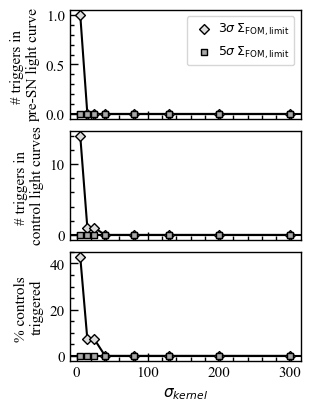

In [19]:
def plot_contamination(contam, sigma_kerns, save=False):
    fig, (ax1, ax2, ax3) = plt.subplots(3, constrained_layout=True)
    fig.set_figwidth(3)
    fig.set_figheight(4)

    fom_limit1_ix = list(np.arange(0, len(sigma_kerns)*2, 2))
    fom_limit2_ix = list(np.arange(1, len(sigma_kerns)*2, 2))

    color_3sigma = 'gainsboro'
    color_5sigma = 'darkgray'
    markersize = 25

    ax3.minorticks_on()
    ax3.tick_params(direction='in', which='both')
    ax3.set_xlabel(r'$\sigma_{kernel}$')
    ax3.set_ylabel(f'% controls \ntriggered',fontsize=11)
    ax3.axhline(color='k', zorder=0)
    ax3.scatter(contam.loc[fom_limit1_ix, 'sigma_kern'], contam.loc[fom_limit1_ix, 'pct_controls_triggered'], 
                color=color_3sigma, edgecolors='k', marker='D', s=markersize, label=r'$3\sigma\: \Sigma_{\rm FOM, limit}$', zorder=30)
    ax3.plot(contam.loc[fom_limit1_ix, 'sigma_kern'], contam.loc[fom_limit1_ix, 'pct_controls_triggered'], color='k', zorder=20)
    ax3.scatter(contam.loc[fom_limit2_ix, 'sigma_kern'], contam.loc[fom_limit2_ix, 'pct_controls_triggered'], 
                color=color_5sigma, edgecolors='k', marker='s', s=markersize, label=r'$5\sigma\: \Sigma_{\rm FOM, limit}$', zorder=30)
    ax3.plot(contam.loc[fom_limit2_ix, 'sigma_kern'], contam.loc[fom_limit2_ix, 'pct_controls_triggered'], color='k', zorder=20)

    ax2.set_xticklabels([])
    ax2.minorticks_on()
    ax2.tick_params(direction='in', which='both')
    ax2.set_ylabel(f'# triggers in \ncontrol light curves',fontsize=11)
    ax2.axhline(color='k', zorder=0)
    ax2.scatter(contam.loc[fom_limit1_ix, 'sigma_kern'], contam.loc[fom_limit1_ix, 'n_triggers'], 
                color=color_3sigma, edgecolors='k', marker='D', s=markersize, label=r'$3\sigma\: \Sigma_{\rm FOM, limit}$', zorder=30)
    ax2.plot(contam.loc[fom_limit1_ix, 'sigma_kern'], contam.loc[fom_limit1_ix, 'n_triggers'], color='k', zorder=20)
    ax2.scatter(contam.loc[fom_limit2_ix, 'sigma_kern'], contam.loc[fom_limit2_ix, 'n_triggers'], 
                color=color_5sigma, edgecolors='k', marker='s', s=markersize, label=r'$5\sigma\: \Sigma_{\rm FOM, limit}$', zorder=30)
    ax2.plot(contam.loc[fom_limit2_ix, 'sigma_kern'], contam.loc[fom_limit2_ix, 'n_triggers'], color='k', zorder=20)

    ax1.minorticks_on()
    ax1.tick_params(direction='in', which='both')
    ax1.set_xticklabels([])
    ax1.set_ylabel(f'# triggers in \npre-SN light curve',fontsize=11)
    ax1.axhline(color='k', zorder=0)
    ax1.scatter(contam.loc[fom_limit1_ix, 'sigma_kern'], contam.loc[fom_limit1_ix, 'n_triggers_00'], 
                color=color_3sigma, edgecolors='k', marker='D', s=markersize, label=r'$3\sigma\: \Sigma_{\rm FOM, limit}$', zorder=30)
    ax1.plot(contam.loc[fom_limit1_ix, 'sigma_kern'], contam.loc[fom_limit1_ix, 'n_triggers_00'], color='k', zorder=20)
    ax1.scatter(contam.loc[fom_limit2_ix, 'sigma_kern'], contam.loc[fom_limit2_ix, 'n_triggers_00'], 
                color=color_5sigma, edgecolors='k', marker='s', s=markersize, label=r'$5\sigma\: \Sigma_{\rm FOM, limit}$', zorder=30)
    ax1.plot(contam.loc[fom_limit2_ix, 'sigma_kern'], contam.loc[fom_limit2_ix, 'n_triggers_00'], color='k', zorder=20)
    ax1.legend(handletextpad=0.1)

    if save:
        save_plot(save_filename='contam')

plot_contamination(contam, sigma_kerns, save=save)

## Get new detection limits by manipulating contamination

### Get new detection limits $\Sigma_{\rm FOM, limit}$

Increase or decrease each $\sigma_{\rm kernel}$'s $3\sigma$ detection limit $\Sigma_{\rm FOM, limit}$ until the resulting contamination reaches the target criteria. 

In [20]:
# Enter the column name of the measure you want to use to represent contamination
# (must be 'pct_controls_triggered' or 'n_triggers'):
tgt_colname = 'pct_controls_triggered'

# Enter the target value for that measure:
tgt_value = 10

# Enter the tolerance for the target value:
tgt_tolerance = 2

# Enter the step size for increasing or decreasing an FOM limit:
fom_limit_step = 0.5

# load effiency tables
load = True
load_filename = 'new_contamination.txt'

# Save new contamination table to tables_dir?:
save = False
save_filename = 'new_contamination.txt'

In [21]:
tables_dir = '/Users/sofiarest/Desktop/Supernovae/data/temp/2023ixf/bump_analysis/tables_allmjd'

In [22]:
def get_new_contamination_table(lc, contam, tgt_colname, tgt_value, tgt_tolerance, fom_limit_step, valid_seasons, skip_control_ix, verbose=False, save=False):
    print(f'Calculating new contamination table using target {tgt_colname} {tgt_value:0.2f}, tolerance {tgt_tolerance:0.2f}, and FOM limit step size {fom_limit_step:0.2f}...')
    
    new_fom_limits = {}

    upper_bound = tgt_value + tgt_tolerance
    lower_bound = tgt_value - tgt_tolerance
    print(f'Upper bound on target {tgt_colname}: {upper_bound:0.2f}')
    print(f'Lower bound on target {tgt_colname}: {lower_bound:0.2f}')

    # remove 5-sigma fom limit rows
    contam = contam[contam.index % 2 == 0]
    contam.reset_index(inplace=True, drop=True)

    for i in range(len(contam)):
        sigma_kern = contam.loc[i,'sigma_kern']
        new_fom_limit = contam.loc[i,'fom_limit']

        if verbose:
            print(f'# sigma_kern {sigma_kern}, 3σ fom_limit {new_fom_limit:0.2f} with {tgt_colname} {contam.loc[i,tgt_colname]:0.2f}')

        while contam.loc[i,tgt_colname] < lower_bound or contam.loc[i,tgt_colname] > upper_bound:
            if contam.loc[i,tgt_colname] > upper_bound:
                new_fom_limit += fom_limit_step # loosen limit
                new_row = get_contamination(lc, sigma_kern, new_fom_limit, valid_seasons, skip_control_ix)

                if verbose:
                    print(f'## FOM limit loosened to {new_fom_limit:0.2f} with {tgt_colname} {new_row[tgt_colname]:0.2f}')

                old_diff = contam.loc[i,tgt_colname] - upper_bound
                new_diff = lower_bound - new_row[tgt_colname]
                if new_row[tgt_colname] < lower_bound and old_diff < new_diff: # step size too big
                    break
                else:
                    contam.loc[i,:] = new_row
                    
            else: # pct_controls_triggered < lower_bound
                new_fom_limit -= fom_limit_step # tighten limit
                new_row = get_contamination(lc, sigma_kern, new_fom_limit, valid_seasons, skip_control_ix)

                if verbose:
                    print(f'## FOM limit tightened to {new_fom_limit:0.2f} with {tgt_colname} {new_row[tgt_colname]:0.2f}')

                old_diff = lower_bound - contam.loc[i,tgt_colname]
                new_diff = new_row[tgt_colname] - upper_bound
                if new_row[tgt_colname] > upper_bound and old_diff < new_diff: # step size too big
                    break
                else:
                    contam.loc[i,:] = new_row
        
        if verbose:
            print(f'## sigma_kern {sigma_kern}, new 3σ fom_limit {contam.loc[i,"fom_limit"]:0.2f} with {tgt_colname} {contam.loc[i,tgt_colname]:0.2f}')
        new_fom_limits[sigma_kern] = [round(contam.loc[i,"fom_limit"], 2)]

    
    if verbose:
        # print MJDs of triggers
        print('\nPrinting MJDs of triggers...')
        for i in range(len(contam)):
            get_contamination(lc, contam.loc[i,'sigma_kern'], contam.loc[i,'fom_limit'], valid_seasons, skip_control_ix, verbose=True)

    if save:
        contam.to_string(f'{tables_dir}/new_contamination.txt')
    return contam, new_fom_limits

def load_new_contamination(lc, contam, tgt_colname, tgt_value, tgt_tolerance, fom_limit_step, valid_seasons, skip_control_ix, load_filename=None, save_filename=None, load=False, save=False):
    if load:
        print(f'Loading contamination table at {load_filename}...')
        new_contam = pd.read_table(f'{tables_dir}/{load_filename}', delim_whitespace=True)

        print(f'Setting FOM limits...')
        new_fom_limits = {}
        for i in range(len(new_contam)):
            sigma_kern = new_contam.loc[i,'sigma_kern']
            fom_limit = new_contam.loc[i,'fom_limit']
            if sigma_kern in new_fom_limits:
                new_fom_limits[sigma_kern].append(fom_limit)
            else:
                new_fom_limits[sigma_kern] = [fom_limit]
    else:
        new_contam, new_fom_limits = get_new_contamination_table(lc, copy.deepcopy(contam), tgt_colname, tgt_value, tgt_tolerance, fom_limit_step, valid_seasons, skip_control_ix, verbose=True, save=save)
    
    print('\n',new_contam.to_string())
    print(f'New FOM limits: {new_fom_limits}')

    if save:
        print(f'Saving contamination table at {save_filename}...')
        new_contam.to_string(f'{tables_dir}/{save_filename}', index=False)

    return new_contam, new_fom_limits

new_contam, new_fom_limits = load_new_contamination(lc, contam,  tgt_colname, tgt_value, tgt_tolerance, fom_limit_step, valid_seasons, skip_control_ix, 
                                                    load_filename=load_filename, save_filename=save_filename, load=load, save=save)

Loading contamination table at new_contamination.txt...
Setting FOM limits...

    sigma_kern  fom_limit  n_triggers  n_controls_triggered  pct_controls_triggered  n_triggers_00  n_triggers_01  n_triggers_04  n_triggers_05  n_triggers_06  n_triggers_07  n_triggers_08  n_triggers_09  n_triggers_10  n_triggers_11  n_triggers_12  n_triggers_13  n_triggers_14  n_triggers_15  n_triggers_16
0           5       6.13           1                     1                    7.14              0              0              0              0              0              0              0              0              1              0              0              0              0              0              0
1          15      10.24           1                     1                    7.14              0              0              0              0              0              0              0              0              0              0              0              0              1              0            

### Plot new detection limits $\Sigma_{\rm FOM,limit}$

In [23]:
# Plot illustratory histograms:
plot = True

# Plot x limits (set to None for automatic):
xlims = (-100,120)

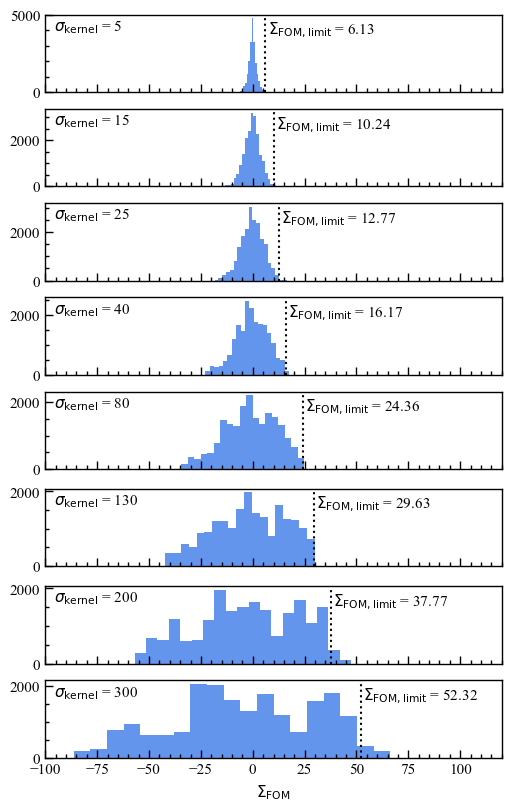

In [24]:
plot_fom_dists(sigma_kerns, all_fom_dict, new_fom_limits, xlims=xlims)

### Plot new contamination

In [ ]:
# Plot new contamination?:
plot = True

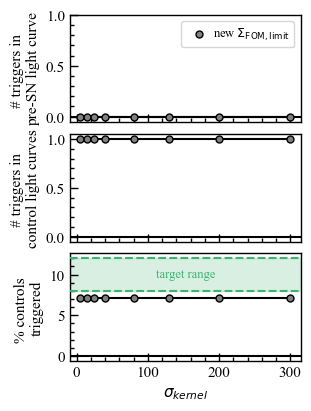

In [25]:
def plot_new_contamination(contam, tgt_colname, tgt_value, tgt_tolerance, save=False):
    fig, (ax1, ax2, ax3) = plt.subplots(3, constrained_layout=True)
    fig.set_figwidth(3)
    fig.set_figheight(4)

    markersize = 25
    upper_bound = tgt_value+tgt_tolerance
    lower_bound = tgt_value-tgt_tolerance

    ax3.minorticks_on()
    ax3.tick_params(direction='in', which='both')
    ax3.set_xlabel(r'$\sigma_{kernel}$')
    ax3.set_ylabel(f'% controls \ntriggered',fontsize=11)
    ax3.axhline(color='k', zorder=0)
    ax3.scatter(contam['sigma_kern'], contam['pct_controls_triggered'], color='gray', edgecolors='k', marker='o', s=markersize, zorder=30)
    ax3.plot(contam['sigma_kern'], contam['pct_controls_triggered'], color='k', zorder=20)
    if tgt_colname == 'pct_controls_triggered':
        ax3.axhline(upper_bound, color='mediumseagreen', linestyle='dashed', zorder=5)
        ax3.axhline(lower_bound, color='mediumseagreen', linestyle='dashed', zorder=5)
        ax3.axhspan(lower_bound, upper_bound, color='mediumseagreen', alpha=0.2, zorder=0)
        ax3.text(0.5, tgt_value, 'target range', fontsize=9, color="mediumseagreen", transform=ax3.get_yaxis_transform(), ha="center", va="center", zorder=5) 

    ax2.set_xticklabels([])
    ax2.minorticks_on()
    ax2.tick_params(direction='in', which='both')
    ax2.set_ylabel(f'# triggers in \ncontrol light curves',fontsize=11)
    ax2.axhline(color='k', zorder=0)
    ax2.scatter(contam['sigma_kern'], contam['n_triggers'], color='gray', edgecolors='k', marker='o', s=markersize, zorder=30)
    ax2.plot(contam['sigma_kern'], contam['n_triggers'], color='k', zorder=20)
    if tgt_colname == 'n_triggers':
        ax2.axhline(upper_bound, color='mediumseagreen', linestyle='dashed', label='Upper bound on target value', zorder=5)
        ax2.axhline(lower_bound, color='mediumseagreen', linestyle='dashed', label='Lower bound on target value', zorder=5)
        ax2.axhspan(lower_bound, upper_bound, color='mediumseagreen', alpha=0.2, zorder=0)
        ax2.text(0.5, tgt_value, 'target range', fontsize=9, color="mediumseagreen", transform=ax2.get_yaxis_transform(), ha="center", va="center", zorder=5) 

    ax1.minorticks_on()
    ax1.tick_params(direction='in', which='both')
    ax1.set_xticklabels([])
    ax1.set_ylabel(f'# triggers in \npre-SN light curve',fontsize=11)
    ax1.axhline(color='k', zorder=0)
    ax1.scatter(contam['sigma_kern'], contam['n_triggers_00'], color='gray', edgecolors='k', marker='o', s=markersize, label=r'new $\Sigma_{\rm FOM, limit}$', zorder=30)
    ax1.plot(contam['sigma_kern'], contam['n_triggers_00'], color='k', zorder=20)
    ylim_lower, ylim_upper = ax1.get_ylim()
    ax1.set_ylim(ylim_lower, max(1, ylim_upper))
    ax1.legend(handletextpad=0.1)

    if save:
        save_plot(save_filename='contam_new')

if plot:
    plot_new_contamination(new_contam, tgt_colname, tgt_value, tgt_tolerance, save=save)

### Plot light curve $\Sigma_{\rm FOM}$ with new detection limits $\Sigma_{\rm FOM, limit}$

In [ ]:
# Plot SN and control light curve FOM?:
plot = True

Applying rolling sum to 16 control light curves...
Applying rolling sum to 16 control light curves...


Applying rolling sum to 16 control light curves...


'\nfor sigma_kern in sigma_kerns:\n    plot_fom(lc, sigma_kern, skip_control_ix, new_fom_limits[sigma_kern], all_fom_dict[sigma_kern], valid_seasons=valid_seasons)\n'

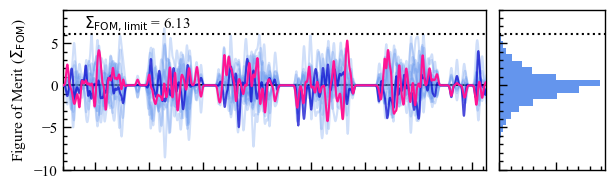

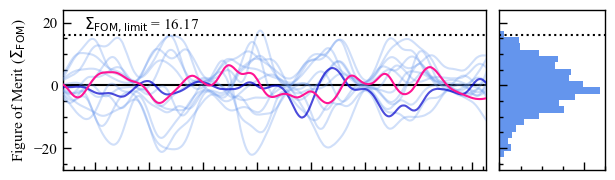

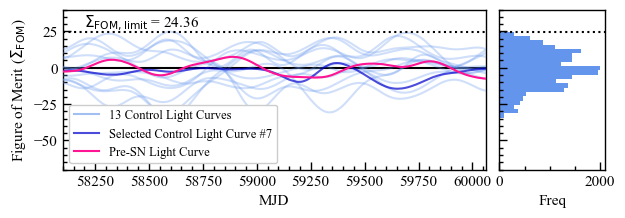

In [26]:
if plot:
    plot_fom(lc, 5, skip_control_ix, new_fom_limits[5], all_fom_dict[5], valid_seasons=valid_seasons, ylims=(-10,9), show_xlabels=False)
    plot_fom(lc, 40, skip_control_ix, new_fom_limits[40], all_fom_dict[40], valid_seasons=valid_seasons, ylims=(-27,24), show_xlabels=False)
    plot_fom(lc, 80, skip_control_ix, new_fom_limits[80], all_fom_dict[80], valid_seasons=valid_seasons, ylims=(-70,40))

    """
    for sigma_kern in sigma_kerns:
        plot_fom(lc, sigma_kern, skip_control_ix, new_fom_limits[sigma_kern], all_fom_dict[sigma_kern], valid_seasons=valid_seasons)
    """

## Efficiencies

In [27]:
# load effiency tables
load = True
load_filename_s1 = 'efficiencies_s1.txt'
load_filename_s2 = 'efficiencies_s2.txt'

# save efficiency tables
save = False
save_filename_s1 = 'efficiencies_s1.txt'
save_filename_s2 = 'efficiencies_s2.txt'

sigma_sims = [[2, 5, 20, 40, 80, 120], # 5
              [2, 5, 20, 40, 80, 120], # 15
              [2, 5, 20, 40, 80, 120], # 15
              [5, 20, 40, 80, 110, 150, 200, 250], # 40
              [5, 20, 40, 80, 110, 150, 200, 250], # 80
              [20, 40, 80, 110, 150, 200, 250, 300], # 130
              [20, 40, 80, 110, 150, 200, 250, 300], # 200
              [20, 40, 80, 110, 150, 200, 250, 300]] # 300
peak_fluxes = [2.29, 3.22, 4.52, 6.34, 8.9, 12.5, 17.55, 24.64, 34.59, 48.56, 68.18, 95.73, 134.41, 188.71, 264.95, 371.99, 522.27, 733.27, 1029.51, 1445.44]
peak_appmags = [23.0, 22.63, 22.26, 21.89, 21.53, 21.16, 20.79, 20.42, 20.05, 19.68, 19.32, 18.95, 18.58, 18.21, 17.84, 17.47, 17.11, 16.74, 16.37, 16.0]

In [29]:
def load_efficiencies(sigma_kerns, peak_appmags, peak_fluxes, sigma_sims, fom_limits, tables_dir, valid_seasons, load_filename=None, save_filename=None, sd=None, load=False, save=False):
    e = EfficiencyTable(sigma_kerns, peak_appmags, peak_fluxes, sigma_sims, fom_limits=fom_limits)
    #e.set_fom_limits(fom_limits)
    print(f'sigma_kerns: {e.sigma_kerns}')
    print(f'sigma_sims: {e.sigma_sims}')
    print(f'FOM limits: {e.fom_limits}')

    if load:
        if load_filename is None:
            raise RuntimeError(f'ERROR: load set to {load} but load_filename is None')
        e.load(tables_dir, load_filename) # load sample 1 efficiency table
    else:
        # recalculate efficiencies using FOM limits
        e.reset()
        if sd is None:
            raise RuntimeError(f'ERROR: load set to {load} but sd (simulation detection tables dictionary) is None')
        print(f'Recalculating efficiencies...')
        e.get_efficiencies(sd, mjd_ranges=valid_seasons)
        print('Success')

    if save:
        e.save(tables_dir, filename=save_filename)

    return e

print('Loading all simulation detection tables...')
sd = load_sd_dict(sigma_kerns, peak_appmags, tables_dir)
# DELETE ME
for key in sd:
    sd[key].t['sigma_kern'] = sd[key].t['gauss_sigma'] 
    sd[key].t['sigma_sim'] = sd[key].t['sim_gauss_sigma']
print('Success')

e_s1 = load_efficiencies(sigma_kerns, peak_appmags, peak_fluxes, sigma_sims, new_fom_limits, tables_dir, valid_seasons,
                         load_filename=load_filename_s1, save_filename=save_filename_s1, sd=sd, load=load, save=save)
print(e_s1.t.to_string())

Loading all simulation detection tables...
Loading simulation detection table simdetec_5_23.00.txt...
Loading simulation detection table simdetec_5_22.63.txt...
Loading simulation detection table simdetec_5_22.26.txt...
Loading simulation detection table simdetec_5_21.89.txt...


Loading simulation detection table simdetec_5_21.53.txt...
Loading simulation detection table simdetec_5_21.16.txt...
Loading simulation detection table simdetec_5_20.79.txt...
Loading simulation detection table simdetec_5_20.42.txt...
Loading simulation detection table simdetec_5_20.05.txt...
Loading simulation detection table simdetec_5_19.68.txt...
Loading simulation detection table simdetec_5_19.32.txt...
Loading simulation detection table simdetec_5_18.95.txt...
Loading simulation detection table simdetec_5_18.58.txt...
Loading simulation detection table simdetec_5_18.21.txt...
Loading simulation detection table simdetec_5_17.84.txt...
Loading simulation detection table simdetec_5_17.47.txt...
Loading simulation detection table simdetec_5_17.11.txt...
Loading simulation detection table simdetec_5_16.74.txt...
Loading simulation detection table simdetec_5_16.37.txt...
Loading simulation detection table simdetec_5_16.00.txt...
Loading simulation detection table simdetec_15_23.00.txt

### Plot: efficiencies

In [49]:
# Plot efficiencies?:
plot = True

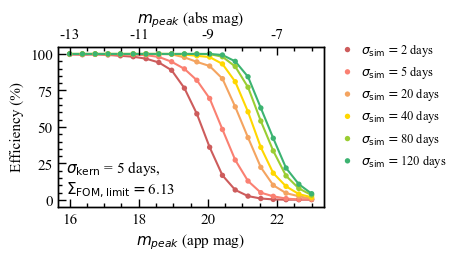

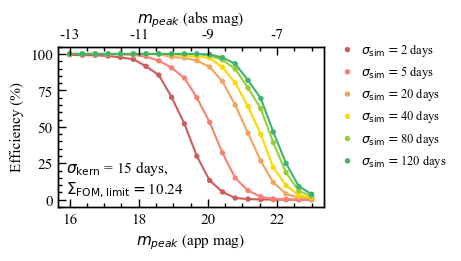

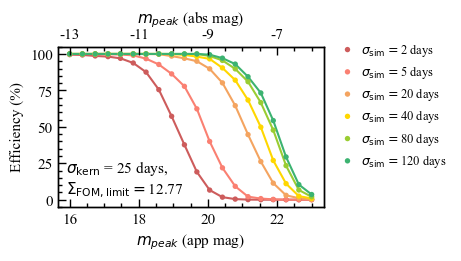

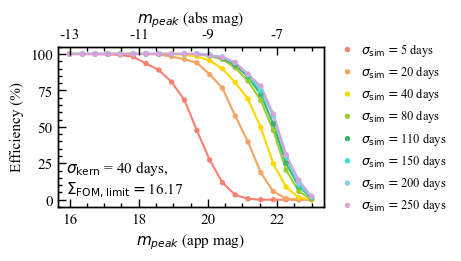

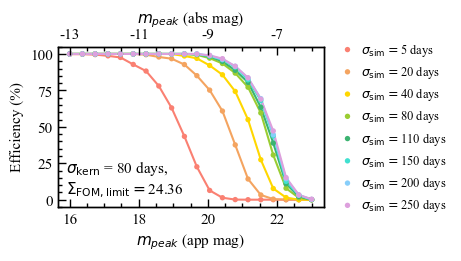

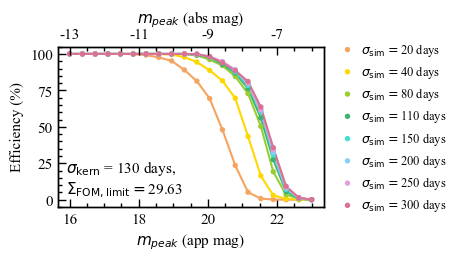

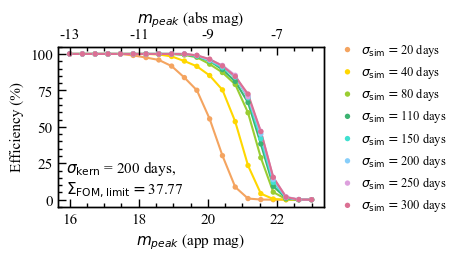

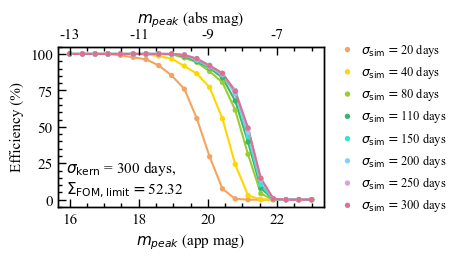

In [63]:
colors = ['indianred', 'salmon', 'sandybrown', 'gold', 'yellowgreen', 'mediumseagreen', 'turquoise', 'lightskyblue', 'plum', 'palevioletred']
plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=colors)

def plot_efficiency(e, sigma_kern):
    fig, ax1 = plt.subplots(1, constrained_layout=True)
    fig.set_figheight(2.5)
    fig.set_figwidth(4.5)

    assert len(e.fom_limits[sigma_kern]) == 1
    fom_limit = e.fom_limits[sigma_kern][0]
    
    ax1.minorticks_on()
    ax1.tick_params(direction='in', which='both')
    ax1.text(.03, .05, r'$\sigma_{\rm kern}$ = '+f'{sigma_kern} days, \n'+r'$\Sigma_{\rm FOM,limit} = $'+f'{fom_limit:0.2f}',
            ha='left', va='bottom', transform=ax1.transAxes, fontsize=11)
    ax1.set_xlabel(r'$m_{peak}$ (app mag)')
    ax1.set_ylabel(f'Efficiency (%)')

    if e.sigma_sims[sigma_kern][0] == 2:
        color_offset = 0
    elif e.sigma_sims[sigma_kern][0] == 5:
        color_offset = 1
    elif e.sigma_sims[sigma_kern][0] == 20:
        color_offset = 2
    else:
        raise RuntimeError('ERROR: not enough colors for sigma_sims')

    for i in range(len(e.sigma_sims[sigma_kern])):
        color = colors[i+color_offset]
        sigma_sim = e.sigma_sims[sigma_kern][i]
        subset = e.get_subset(sigma_kern=sigma_kern, sigma_sim=sigma_sim, fom_limit=fom_limit)
        label = r'$\sigma_{\rm sim} = $'+f'{sigma_sim} days'
        ax1.scatter(subset['peak_appmag'], subset[f'pct_detec_{fom_limit}'], color=color, edgecolors='none', marker='o', label=label, s=15, zorder=20)
        ax1.plot(subset['peak_appmag'], subset[f'pct_detec_{fom_limit}'], color=color, zorder=10)

    ax1.legend(loc='upper left', facecolor='white', fontsize=9, framealpha=0, handletextpad=0.1, bbox_to_anchor=(1, 1.1)).set_zorder(100)

    # abs mag
    ax2 = ax1.twiny()
    ax2.set_xticks(ax1.get_xticks())
    ax2.set_xbound(ax1.get_xbound())
    ax2.minorticks_on()
    ax2.tick_params(direction='in', which='both')
    ax2.set_xticklabels([round(x-29.04) for x in ax1.get_xticks()])
    ax2.set_xlabel("$m_{peak}$ (abs mag)")

if plot:
    for sigma_kern in sigma_kerns:
        plot_efficiency(e_s1, sigma_kern)
        #sys.exit()

### Get magnitude thresholds for 50% and 80% efficiency

In [ ]:
# Save magnitude threshold table?
save = True

In [43]:
def get_mag_threshold(x, y, percent):
    lx = x.to_list()
    lx.reverse()
    ly = y.to_list()
    ly.reverse()

    ly_reduced = np.array(ly) - percent
    freduced = interpolate.UnivariateSpline(lx, ly_reduced, s=0)
    roots = freduced.roots()
    if len(roots) > 1:
        #raise RuntimeError(f'ERROR: Found more than one root: {roots}')
        print(f'WARNING: Found more than one root {roots}; returning NaN')
        return np.nan
    if len(roots) < 1:
        return np.nan
    return roots[0]

def get_mag_threshold_table(e, save=False):
    mt = pd.DataFrame(columns=['sigma_kern', 'sigma_sim', 'fom_limit', 'mag_threshold_80', 'mag_threshold_50'])

    row = 0
    for sigma_kern in e.sigma_kerns:
        for sigma_sim in e.sigma_sims[sigma_kern]:
            for fom_limit in e.fom_limits[sigma_kern]:
                subset = e.get_subset(sigma_kern=sigma_kern, sigma_sim=sigma_sim, fom_limit=fom_limit)
                mag_threshold_80 = get_mag_threshold(subset['peak_appmag'], subset[f'pct_detec_{fom_limit:0.2f}'], 80)
                mag_threshold_50 = get_mag_threshold(subset['peak_appmag'], subset[f'pct_detec_{fom_limit:0.2f}'], 50)
                mt.loc[row] = {'sigma_kern':sigma_kern, 'sigma_sim':sigma_sim, 'fom_limit':fom_limit, 'mag_threshold_80':mag_threshold_80, 'mag_threshold_50':mag_threshold_50}
                row += 1

    print(mt.to_string())
    if save:
        mt.to_string(f'{tables_dir}/mag_thresholds.txt')
    return mt

mt_s1 = get_mag_threshold_table(e_s1, save=save)

    sigma_kern  sigma_sim  fom_limit  mag_threshold_80  mag_threshold_50
0            5          2       6.13         19.233659         19.828618
1            5          5       6.13         19.754762         20.392086
2            5         20       6.13         20.491204         21.032601
3            5         40       6.13         20.811564         21.315454
4            5         80       6.13         21.104650         21.595880
5            5        120       6.13         21.247376         21.754455
6           15          2      10.24         18.734770         19.355353
7           15          5      10.24         19.428286         20.107430
8           15         20      10.24         20.450884         21.077797
9           15         40      10.24         20.794204         21.441252
10          15         80      10.24         21.070065         21.731454
11          15        120      10.24         21.225673         21.838267
12          25          2      12.77         18.464

### Plot: magnitude thresholds

In [107]:
# Plot magnitude thresholds?
plot = True

# Enter plot y limits:
ylims = (17.5, 22.6)

# Save plot?:
save = False

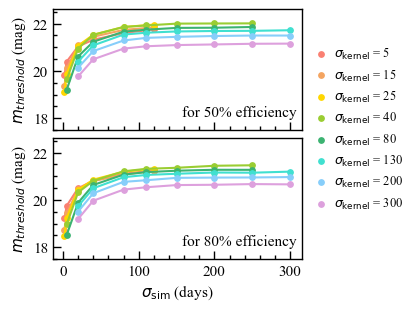

In [108]:
def plot_mag_thresholds(e, mt, ylims=None, save=False):
    fig, (ax1, ax2) = plt.subplots(2,1, constrained_layout=True)
    fig.set_figwidth(3)
    fig.set_figheight(3)

    if not ylims is None:
        ax1.set_ylim(ylims[0],ylims[1])
        ax2.set_ylim(ylims[0],ylims[1])

    ax1.minorticks_on()
    ax1.tick_params(direction='in', which='both')
    ax1.set_ylabel(r'$m_{threshold}$ (mag)')
    ax1.set_xticklabels([])
    ax1.text(.98, .09, f'for 50% efficiency', ha='right', va='bottom', transform=ax1.transAxes, fontsize=11)

    ax2.minorticks_on()
    ax2.tick_params(direction='in', which='both')
    ax2.set_xlabel(r'$\sigma_{\rm sim}$ (days)')
    ax2.set_ylabel(r'$m_{threshold}$ (mag)')
    ax2.text(.98, .09, f'for 80% efficiency', ha='right', va='bottom', transform=ax2.transAxes, fontsize=11)

    for i in range(len(e.sigma_kerns)):
        sigma_kern = e.sigma_kerns[i] 
        sigma_kern_ix = mt[mt['sigma_kern'] == sigma_kern].index

        assert len(e.fom_limits[sigma_kern]) == 1
        fom_limit = e.fom_limits[sigma_kern][0]
        fom_limit_ix = mt[mt['fom_limit'] == fom_limit].index

        ix = AandB(sigma_kern_ix, fom_limit_ix)

        for ax, percent_efficiency in zip([ax1, ax2], [50, 80]):
            label = r'$\sigma_{\rm kernel}$'+f' = {sigma_kern}'
            if percent_efficiency == 80:
                label = None
            ax.scatter(mt.loc[ix,'sigma_sim'], mt.loc[ix,f'mag_threshold_{percent_efficiency}'], s=15, color=colors[i+1], marker='o', label=label, zorder=i*10)
            ax.plot(mt.loc[ix,'sigma_sim'], mt.loc[ix,f'mag_threshold_{percent_efficiency}'], color=colors[i+1], zorder=i*10)

    fig.legend(facecolor='white', framealpha=0, bbox_to_anchor=(0.97, 0.9), handletextpad=0.1, loc='upper left')#, ncol=2)

    if save:
        save_plot(save_filename='mag_thresholds')

if plot:
    plot_mag_thresholds(e_s1, mt_s1, ylims=ylims, save=save)

## Simulating pre-SN outburts

### Plot: adding a simulated Gaussian bump